In [1]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm

In [2]:
from pysim.simulation import simulate

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from math import pi, cos, sin
from pysim.utils import random_hex_string
from pysim.des import Logger

In [9]:
R = 10    # circle radius
H = 1.0   # reader altitude
V = 10.0   # meters per second, reader velocity
D = 2.0   # meters, channel distance

spec = {
    'mobility': {
        'update_timeout': 0.1,
    },
    'reader': {
        'position': (R, 0, H),
        'Q': 2,
        'M': 1,
        'DR': '8',
        'trext': False,
        'sel': 'ALL',
        'tari': 6.25e-6,
        'rtcal': 15.0e-6,
        'trcal': 20.0e-6,
        'session': 0,
        'target': 'A',
        'trajectory': {
            'center': (0, 0, 0),
            'angle0': 0,
            'point_area_radius': D * 1.01,            
            'radius': R,
            'velocity': V,  # meters per second
            'altitude': H,  # meter
        },
        'stats': {
            'record_read_timestamps': False,
        }
    },
    'tags': [{
        'id': i,
        'sensitivity': -20.0,  # dBm
        'position': (cos(pi/3 * i) * R, sin(pi/3 * i) * R, 0),
        'epcid': random_hex_string(24),
        'switch_target': False,
    } for i in range(6)],
    'channel': {
        'model': 'models.channels.ConstantChannel',
        'distance': D,
        'ber': 0.03,
    },
    'propagation': {
        'model': 'models.propagation.NoLossPropagationModel',
        'distance': D,
    },
}

def update_spec(spec, path, value):
    import copy
    new_spec = copy.deepcopy(spec)
    parts = path.split('.')
    last_dict = new_spec
    for part in parts[:-1]:
        last_dict = last_dict[part]
    last_dict[parts[-1]] = value
    return new_spec

In [10]:
velocities = (16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 64.0, 96.0)
speed_specs = [update_spec(spec, 'reader.trajectory.velocity', v) for v in velocities]
sim_time_limits = [(32 - 1/12 - 0.0001) * pi * R / v for v in velocities]

# for rec in zip(speed_specs, sim_time_limits):
#     print(rec)

speed_rets = []
for a_spec, a_limit in tqdm(list(zip(speed_specs, sim_time_limits))):
    speed_rets.append(simulate(a_spec, sim_time_limit=a_limit))

for ret in speed_rets:
    print(ret)

100%|██████████| 13/13 [04:51<00:00, 22.44s/it]

{'tags': [{'id': 0, 'read_count': 65}, {'id': 1, 'read_count': 44}, {'id': 2, 'read_count': 58}, {'id': 3, 'read_count': 58}, {'id': 4, 'read_count': 52}, {'id': 5, 'read_count': 48}], 'c1g2_stats': {'num_collisions': 0}, 'read_timestamps': [], 'routes': [{'t_start': 0, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 1, 'last_round': 7453}, {'t_start': 3.900000000000002, 'tags_read': {0, 1, 2, 3, 4}, 'first_round': 7454, 'last_round': 14807}, {'t_start': 7.799999999999988, 'tags_read': {0, 2, 3, 4, 5}, 'first_round': 14808, 'last_round': 22249}, {'t_start': 11.699999999999974, 'tags_read': {0, 1, 2, 4, 5}, 'first_round': 22250, 'last_round': 29573}, {'t_start': 15.59999999999996, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 29574, 'last_round': 37133}, {'t_start': 19.60000000000001, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 37134, 'last_round': 44392}, {'t_start': 23.500000000000064, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 44393, 'last_round': 51834}, {'t_start': 27.40

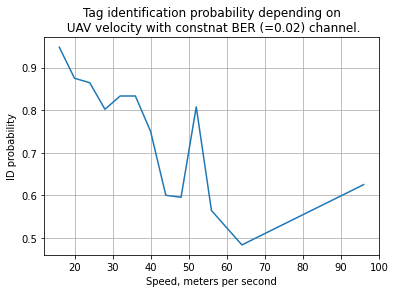

In [23]:
def get_tag_read_prob(sim_ret, num_tags=6):
    probs = []
    routes = sim_ret['routes']
#     print(routes)
    for route in routes:
        num_tags_read = len(route['tags_read'])
#         print('> num_tags_read = ', num_tags_read)
        probs.append(num_tags_read / num_tags)
    return np.mean(probs)

plt.grid()
plt.xlabel('Speed, meters per second')
plt.ylabel('ID probability')
plt.title('Tag identification probability depending on\n UAV velocity with constnat BER (=0.02) channel.')
plt.plot(velocities, [get_tag_read_prob(sr) for sr in speed_rets])
plt.savefig('p_id_vs_speed__ber_0.02.pdf')

In [24]:
bers = (0.030, 0.0325, 0.0350, 0.0375, 0.0400, 0.0425, 0.0450, 0.0475, 0.050, 0.0525, 0.0550, 0.0575, 0.0600)
ber_specs = [update_spec(spec, 'channel.ber', ber) for ber in bers]
sim_time_limit = (12 - 1/12 - 0.0001) * pi * R / V

# for rec in zip(speed_specs, sim_time_limits):
#     print(rec)

ber_rets = []
for spec in tqdm(ber_specs):
    ber_rets.append(simulate(spec, sim_time_limit))

for ret in ber_rets:
    print(ret)

100%|██████████| 13/13 [05:52<00:00, 27.10s/it]

{'tags': [{'id': 0, 'read_count': 35}, {'id': 1, 'read_count': 34}, {'id': 2, 'read_count': 31}, {'id': 3, 'read_count': 35}, {'id': 4, 'read_count': 45}, {'id': 5, 'read_count': 38}], 'c1g2_stats': {'num_collisions': 0}, 'read_timestamps': [], 'routes': [{'t_start': 0, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 1, 'last_round': 11518}, {'t_start': 6.099999999999994, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 11519, 'last_round': 23466}, {'t_start': 12.399999999999972, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 23467, 'last_round': 35323}, {'t_start': 18.699999999999996, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 35324, 'last_round': 47165}, {'t_start': 25.000000000000085, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 47166, 'last_round': 59041}, {'t_start': 31.300000000000175, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 59042, 'last_round': 70520}]}
{'tags': [{'id': 0, 'read_count': 20}, {'id': 1, 'read_count': 21}, {'id': 2, 'read_count': 25}, {'id': 3, 'rea

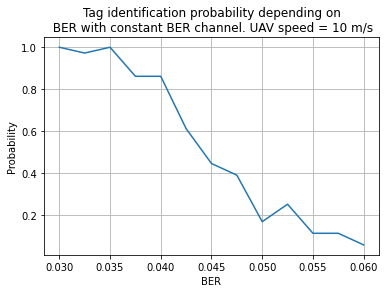

In [28]:
plt.grid()
plt.xlabel('BER')
plt.ylabel('Probability')
plt.title('Tag identification probability depending on\n BER with constant BER channel. UAV speed = 10 m/s')
plt.plot(bers, [get_tag_read_prob(sr) for sr in ber_rets])
plt.savefig('p_id_vs_ber__speed_10.pdf')

In [29]:
dist_spec = update_spec(spec, 'reader.stats.record_read_timestamps', True)
dist_spec = update_spec(dist_spec, 'channel.ber', 0.03)
dist_ret = simulate(dist_spec, sim_time_limit)

<ipython-input-40-9ab56c16aeac>:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax0.stem(time_intervals)
<ipython-input-40-9ab56c16aeac>:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax2.stem(time_intervals)


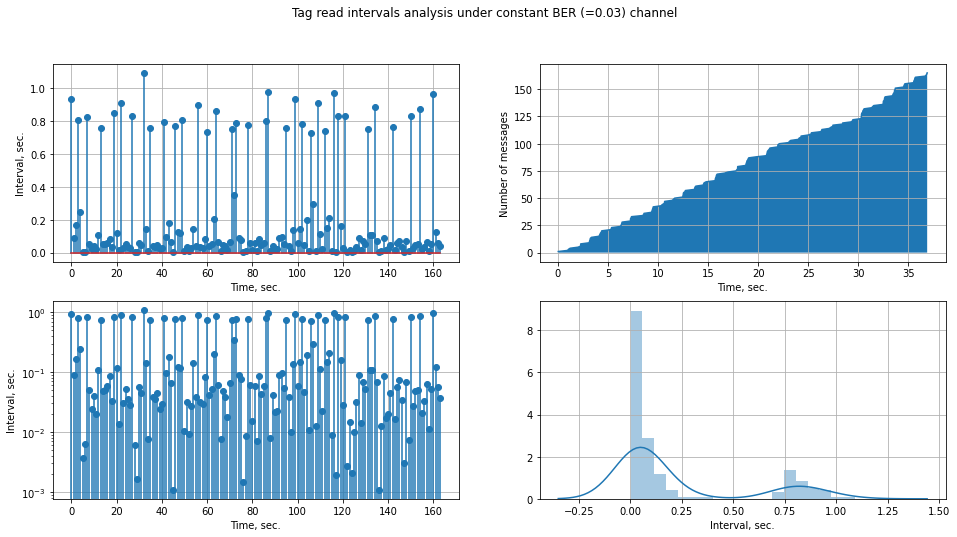

In [40]:
timestamps = np.asarray(dist_ret['read_timestamps'])
time_intervals = np.diff(timestamps)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
fig.suptitle('Tag read intervals analysis under constant BER (=0.03) channel')

ax0.stem(time_intervals)
ax0.set_xlabel('Time, sec.')
ax0.set_ylabel('Interval, sec.')

ax1.plot(timestamps, range(1, len(timestamps) + 1))
ax1.fill_between(timestamps, range(1, len(timestamps) + 1))
ax1.set_xlabel('Time, sec.')
ax1.set_ylabel('Number of messages')


import seaborn as sns
sns.distplot(time_intervals, ax=ax3)
ax3.set_xlabel('Interval, sec.')

ax2.stem(time_intervals)
ax2.set_yscale('log')
ax2.set_xlabel('Time, sec.')
ax2.set_ylabel('Interval, sec.')

ax0.grid()
ax1.grid()
ax2.grid()
ax3.grid()

fig.savefig('intervals__ber_0.03.pdf')